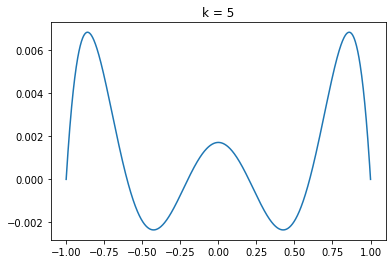

d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RankWarning: The fit may be poorly conditioned
  


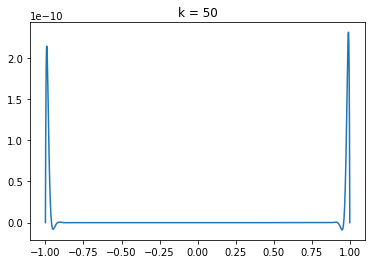

In [10]:
%matplotlib inline

# Exercise 6.1 (a)
import numpy as np
from numpy.polynomial import polynomial
import matplotlib.pyplot as plt

func6_1 = (lambda x: np.exp(- x**2))
x_test = np.linspace(-1, 1, 1000)
y_test = func6_1(x_test)

def interpolate6_1a(k, x_fit=x_test):
    x_eval = np.linspace(-1, 1, k + 1)
    coef = polynomial.polyfit(x_eval, func6_1(x_eval), k)
    y_fit = np.dot(polynomial.polyvander(x_fit, k), coef)
    return coef, y_fit

def check_fit(method, k):
    coef, y_fit = method(k)
    plt.plot(x_test, y_test - y_fit)
    plt.title('k = ' + str(k))
    plt.show()
    return None

for k in [5, 50]:
    check_fit(interpolate6_1a, k)


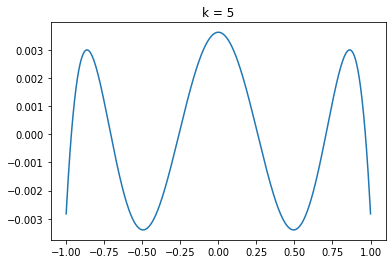

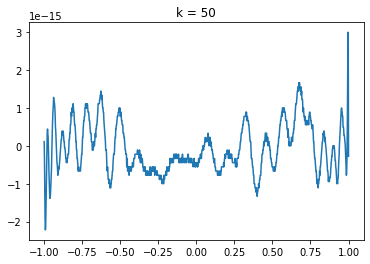

In [11]:
%matplotlib inline

# Exercise 6.1 (b)
from numpy.polynomial import chebyshev

def get_chebyshev_node(a, b, k):
    x_tmp = np.array([np.cos(np.pi * (2 * i - 1) / (2 * k))
        for i in range(1, k + 1)])
    return (a + b) / 2 + (b - a) * x_tmp / 2

def interpolate6_1b(k, x_fit=np.linspace(-1, 1, 1000)):
    x_eval = get_chebyshev_node(-1, 1, k+1)
    coef = chebyshev.chebfit(x_eval, func6_1(x_eval), k)
    y_fit = chebyshev.chebval(x_fit, coef)
    return coef, y_fit

for k in [5, 50]:
    check_fit(interpolate6_1b, k)

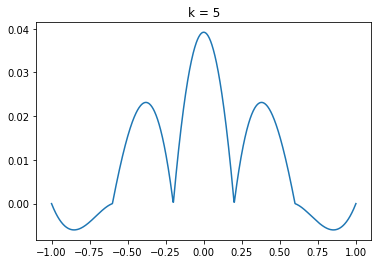

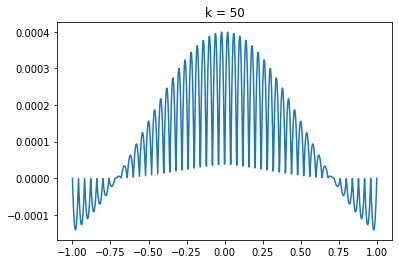

In [12]:
%matplotlib inline

# Exercise 6.1 (c)
from scipy import interpolate

def interpolate6_1c(n, k, x_fit=x_test):
    x_eval = np.linspace(-1, 1, n + 1)
    tck = interpolate.splrep(x_eval, func6_1(x_eval), k=k)
    y_fit = interpolate.splev(x_fit, tck)
    return tck, y_fit

for n in [5, 50]:
    check_fit((lambda n: interpolate6_1c(n, 1)), n)

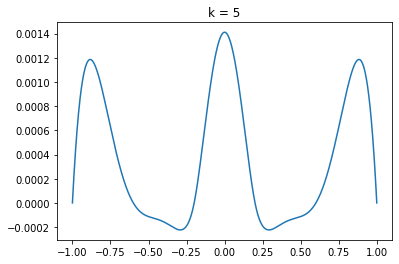

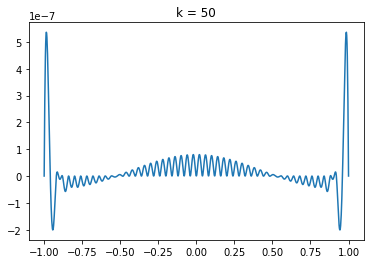

In [13]:
# Exercise 6.1 (d)
for n in [5, 50]:
    check_fit((lambda n: interpolate6_1c(n, 3)), n)

Converged with order-12 polynomial


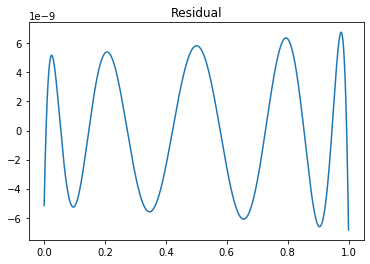

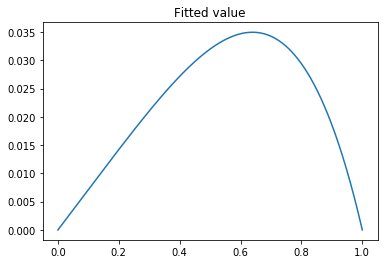

In [14]:
%matplotlib inline

# Exercise 6.4
from scipy import integrate, optimize

def get_resid6_4(params, x_eval):
    v = chebyshev.chebval(x_eval, params)
    params_der2 = chebyshev.chebder(params, m=2)
    vder2 = chebyshev.chebval(x_eval, params_der2)

    resid_main = (1 + x_eval**2) * v - vder2 - x_eval**2
    resid_sub = chebyshev.chebval(np.array([0, 1]), params)
    return np.concatenate((resid_main, resid_sub))

def get_max_resid6_4(sol, x_fit):
    resid = get_resid6_4(sol, x_fit)
    return max(abs(resid[:-2]))

def solver_sub6_4(k):
    """ Since boundary condition gives 2 additional constraints
        we use (k - 2) nodes for interpolation. 
    """
    x_eval, init = get_chebyshev_node(0, 1, k - 2), np.zeros(k)
    func_aux = (lambda params: get_resid6_4(params, x_eval))
    sol = optimize.broyden1(func_aux, xin=init, f_tol=1.0e-10)
    return sol

def solver6_4(x_fit, tol=1.0e-8, maxiter=50):
    for k in range(1, maxiter):
        sol = solver_sub6_4(k)
        if get_max_resid6_4(sol, x_fit) < tol:
            print('Converged with order-{0:.0f} polynomial'.format(k))
            return sol, k
    raise ValueError('No convergence')

x_fit = np.linspace(0, 1, 10000)
sol, k = solver6_4(x_fit)

y_fit = chebyshev.chebval(x_fit, sol)
resid = get_resid6_4(sol, x_fit)[:-2]

plt.plot(x_fit, resid)
plt.title('Residual')
plt.show()

plt.plot(x_fit, y_fit)
plt.title('Fitted value')
plt.show()


Converged with order-19 polynomial


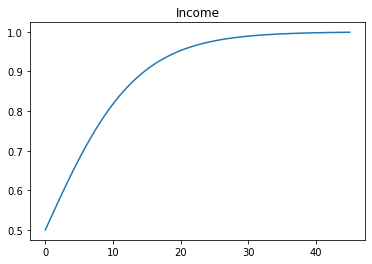

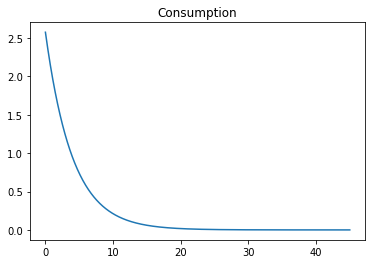

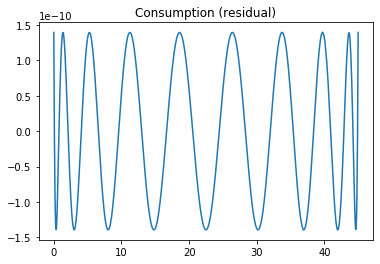

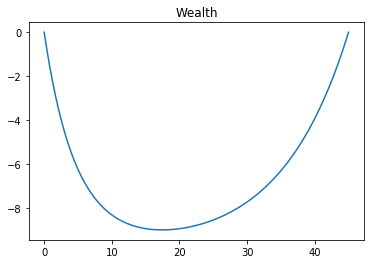

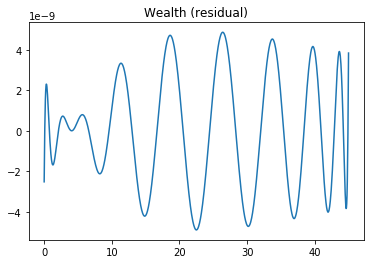

In [15]:
%matplotlib inline

# Exercise 6.5 (a)

# Agenet class
class Agent:

    def __init__(self, T, lm, rho, r, alpha):
        self.T, self.lm, self.rho, self.r, self.alpha \
            = T, lm, rho, r, alpha

    def income(self, t):
        return 1 / (1 + np.exp(-self.alpha * t))

    def euler_eq(self, c):
        return c * (self.r - self.rho) / (self.lm)

    def savings(self, w, c, t):
        return self.r * w + self.income(t) - c

# Evaluate residuals
def evaluate_fval_fjac(t_eval, params_x):
    x = chebyshev.chebval(t_eval, params_x)
    dparams_x = chebyshev.chebder(params_x)
    dx = chebyshev.chebval(t_eval, dparams_x)
    return x, dx

def get_resid6_5a(k, t_eval, params, agent):
    params_c, params_w = params[:k], params[k:]
    c, dc = evaluate_fval_fjac(t_eval, params_c)
    w, dw = evaluate_fval_fjac(t_eval, params_w)
    
    resid_c = dc - agent.euler_eq(c)
    resid_w = dw - agent.savings(w, c, t_eval)
    boundary_cond = chebyshev.chebval(np.array([0, agent.T]), params_w)
    return np.concatenate((resid_c, resid_w, boundary_cond))

def get_max_resid6_5(k, t_eval, params, agent):
    resid = get_resid6_5a(k, t_eval, params, agent)
    return max(abs(resid[:-2]))

# Solve the problem
def solver_sub6_5a(k, agent):
    t_eval = get_chebyshev_node(0, agent.T, k - 1)
    func_aux = (lambda params: get_resid6_5a(k, t_eval, params, agent))
    return optimize.root(func_aux, x0=np.zeros(2 * k), tol=1.0e-10)

def solver6_5a(agent, t_fit, tol=1.0e-8, maxiter=50):
    for k in range(2, maxiter + 1):
        sol = solver_sub6_5a(k, agent).x
        resid_max = get_max_resid6_5(k, t_fit, sol, agent)
        if resid_max < tol:
            print('Converged with order-{0:.0f} polynomial'.format(k))
            return sol, k

    raise ValueError('No convergence')


T, lm, rho, r, alpha = 45, 2, 0.6, 0.1, 0.15
t_fit = np.linspace(0, T, 1000)
agent = Agent(T, lm, rho, r, alpha)

sol, k = solver6_5a(agent, t_fit)

# Visualize the result
params_c, params_w = sol[:k], sol[k:]

plt.plot(t_fit, agent.income(t_fit))
plt.title('Income')
plt.show()

c_fit = chebyshev.chebval(t_fit, params_c)
plt.plot(t_fit, c_fit)
plt.title('Consumption')
plt.show()

resid = get_resid6_5a(k, t_fit, sol, agent)[:-2]
resid_c, resid_w = resid[:len(t_fit)], resid[len(t_fit):]

plt.plot(t_fit, resid_c)
plt.title('Consumption (residual)')
plt.show()

w_fit = chebyshev.chebval(t_fit, params_w)
plt.plot(t_fit, w_fit)
plt.title('Wealth')
plt.show()

plt.plot(t_fit, resid_w)
plt.title('Wealth (residual)')
plt.show()


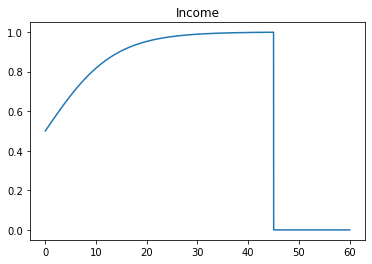

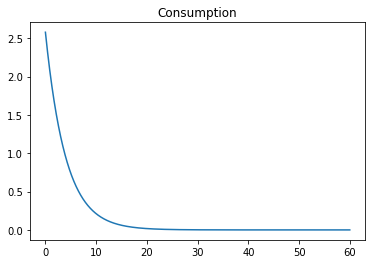

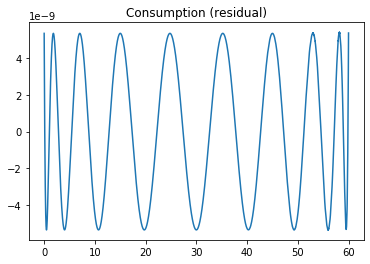

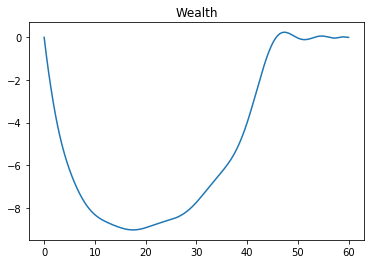

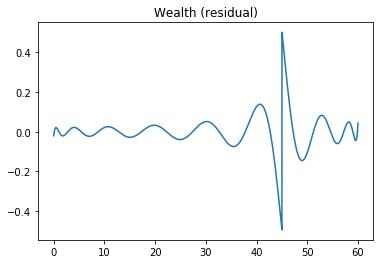

In [16]:
# Exercise 6.5 (b)
class AgentRetire(Agent):

    def __init__(self, T, lm, rho, r, alpha, R):
        super().__init__(T, lm, rho, r, alpha)
        self.R = R

    def income(self, t):
        flag_working = np.vectorize(lambda x: x <= self.T - self.R)(t)
        return flag_working * 1 / (1 + np.exp(-self.alpha * t))

# Solve the problem
R = 15
t_fit_retire = np.linspace(0, T + R, 10000)
agent_retire = AgentRetire(T + R, lm, rho, r, alpha, R)
k = 19
sol = solver_sub6_5a(k, agent_retire)
params_c, params_w = sol.x[:k], sol.x[k:]

# Visualize the result
plt.plot(t_fit_retire, agent_retire.income(t_fit_retire))
plt.title('Income')
plt.show()

c_fit_retire = chebyshev.chebval(t_fit_retire, params_c)
plt.plot(t_fit_retire, c_fit_retire)
plt.title('Consumption')
plt.show()

resid_retire = get_resid6_5a(k, t_fit_retire, sol.x, agent_retire)[:-2]
resid_retire_c, resid_retire_w \
    = resid_retire[:len(t_fit_retire)], resid_retire[len(t_fit_retire):]

plt.plot(t_fit_retire, resid_retire_c)
plt.title('Consumption (residual)')
plt.show()

w_fit_retire = chebyshev.chebval(t_fit_retire, params_w)
plt.plot(t_fit_retire, w_fit_retire)
plt.title('Wealth')
plt.show()

plt.plot(t_fit_retire, resid_retire_w)
plt.title('Wealth (residual)')
plt.show()


**Exercise 6.5 (continued)**
Due to the kink in the income profile at 45, the approximation of the wealth profile becomes poor particularly around the retirement age. This problem is alleviated by using spline method (with the retirement age as a break point).

**Exercise 6.6 (a)**
By taking the derivative, we observe
$$
u'(x) = x u(x) - \frac{1}{\sqrt{2 \pi}}
$$

**Exercise 6.6 (b)**
Let $v(t) = v (t(x)) = u(x)$ with $t = x / (K + x)$. Then,
$$
x = \frac{tK}{1 - t}; \qquad \frac{dt}{dx} = v'(t) \frac{K}{(K + x)^2} = v'(t) \frac{(1-t)^2}{K}
$$
Hence, substituting these into the differential equation derived in (a), we get
$$
v'(t) \frac{(1-t)^2}{K} = \frac{tK}{1 - t} v(t) - \frac{1}{\sqrt{2 \pi}}
$$
for $t \in [0, 1)$ with $v(1) = 0$ as a boundary condition. Notice that this problem is rewritten as
$$
v'(t) \frac{(1-t)^3}{K} = tK v(t) - \frac{1 - t}{\sqrt{2 \pi}}
$$
for $t \in [0, 1]$, because this equation implies $v(1) = 0$.

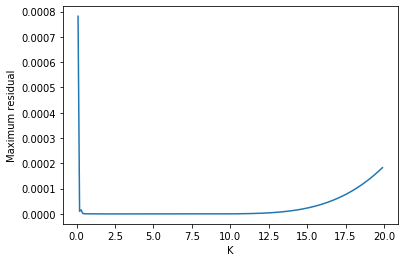

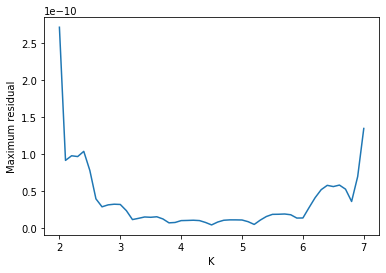

The residual is minimized when K = 4.5


In [17]:
# Exercise 6.6 (c) and (d)
def get_resid6_6(params, t_eval, K):
    v = chebyshev.chebval(t_eval, params)
    params_der = chebyshev.chebder(params)
    vder = chebyshev.chebval(t_eval, params_der)

    return vder * (1 - t_eval)**3 / K - K * t_eval * v \
        + (1 - t_eval) / np.sqrt(2 * np.pi)

def get_max_resid6_6(params, t_eval, K):
    return max(abs(get_resid6_6(params, t_eval, K)))

def solver_sub6_6(k, K):
    t_eval, init = get_chebyshev_node(0, 1, k + 1), np.zeros(k + 1)
    func_aux = (lambda params: get_resid6_6(params, t_eval, K))
    return optimize.root(func_aux, x0=init)

k, t_fit, Ks = 15, np.linspace(0, 1, 10000), np.arange(0.1, 20, 0.1)
sols = np.array([solver_sub6_6(k, K) for K in Ks])
resids = np.array([get_max_resid6_6(sol.x, t_fit, K) for K, sol in zip(Ks, sols)])

plt.plot(Ks, resids)
plt.xlabel('K')
plt.ylabel('Maximum residual')
plt.show()

cond = (Ks >= 2) & (Ks <= 7)
plt.plot(Ks[cond], resids[cond])
plt.xlabel('K')
plt.ylabel('Maximum residual')
plt.show()

print('The residual is minimized when K = {0:.1f}'.format(Ks[np.argmin(resids)]))

**Exercise 6.7**
Let $f$ be invertible. Then
$$
x = f^{-1} \left(f (x) \right)
$$
By approximating $f^{-1}$ by
$$
f^{-1} (x) = \sum_{j=1}^{n} c_{j} \phi_{j} (x)
$$
where $\phi_{j}$'s are some base functions, this problem is regarded as the root finding problem:
$$
x - f^{-1} \left(\sum_{j=1}^{n} c_{j} \phi_{j} \left(f (x) \right) \right)
$$

Converged with 94th order


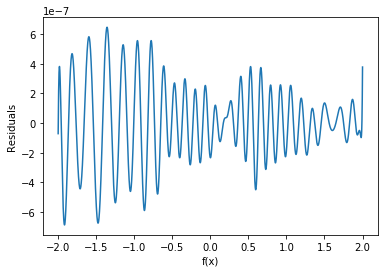

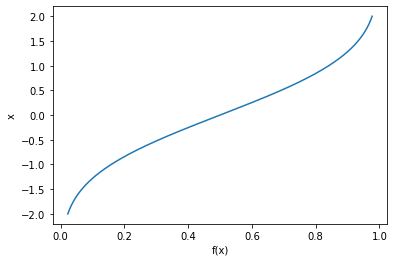

In [18]:
# Exercise 6.7
from scipy import stats

def finverse(f, x_fit, *args):
    f_curried = (lambda x: f(x, *args))
    chebval_wrap = (lambda x, params: chebyshev.chebval(f_curried(x), params))

    def get_params(k):
        x_eval, x0 = get_chebyshev_node(np.min(x_fit), np.max(x_fit), k), np.zeros(k)
        get_residual = (lambda params: x_eval - chebval_wrap(x_eval, params))
        return optimize.root(get_residual, x0=x0, tol=1.0e-10)

    for k in range(1, 200):
        sol = get_params(k)
        f_inv = chebval_wrap(x_fit, sol.x)
        residuals = x_fit - f_inv
        if np.max(abs(residuals)) < 1.0e-6:
            print('Converged with {0:.0f}th order'.format(k))
            plot_finv(x_fit, f_inv, residuals)
            return sol, f_inv, residuals
    raise ValueError('Not converged')

def plot_finv(x_fit, f_inv, residuals):
    plt.plot(x_fit, residuals)
    plt.xlabel('f(x)'), plt.ylabel('Residuals')
    plt.show()

    plt.plot(f_test(x_fit), f_inv)
    plt.xlabel('f(x)'), plt.ylabel('x')
    plt.show()
    return None

f_test = stats.norm.cdf
x_fit = np.linspace(-2, 2, 10000)
sol, f_inv, residuals = finverse(f_test, x_fit)
